In [ ]:
#project 1 group 48

# Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors
import itertools
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
!pip install validclust
from sklearn import metrics
from validclust import dunn
from sklearn.metrics import pairwise_distances,rand_score
from sklearn.metrics.cluster import fowlkes_mallows_score,contingency_matrix
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler,normalize
from google.colab import files
uploaded=files.upload()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 1

## Performing all of the functions that needed further

### Performing the remapping function

In terms of mapping way, we have a solution for this problem by using the permutations. Basically, if we can have all kinds of permutation of the origical class and map them back to the predicted labels one by one. Then we can test all of the accuracy score for each permutation and to get a max value. Then we can say that this is the right way to map the two classes and then all we have to do is just return targeted mapping as our mapping list. For example, in the dataset 1, we have 7! ways to combine the original labels. Then we need to map them with the predicted labels and create a dictionary to create all of the possible ways. Then we can test the accuracy score for each of them and add them into a list and get their max value of accuracy score. This would be the most accurate way of clustering and mapping.

In [ ]:
def remap_label(ground_truth, labels):
    pred_classes = list(set(labels))# Get the unique labels in dataframe after clustering.
    class_list = list(set(ground_truth))# Get the unique labels in original dataframe.
    permutations = itertools.permutations(class_list)# Get all possible permutations of labels in original class and save them into permutations.

    mapping_list = []
    for k in permutations:# Create a for loop to get all of the mapping permutations
        map_dict = {}
        for i in range(len(k)):
            map_dict[pred_classes[i]] = k[i]#Add the unique labels of pred_classes into the dictionary and use them as keys and add all of the permutations that generated from the groundtruth labels under the keys.
        mapping_list.append(map_dict)# and add all of the possible outcomes into the mapping_list.

    acc_list = [] # create a for loop to get all of the accuracy value and add them into a list.
    for i in range(len(mapping_list)):
        correct = sum([mapping_list[i][pred]==gth for gth, pred in zip(ground_truth, labels)])#get total number of the TP valuse for each permutation
        acc_list.append(correct/len(labels))  #calculate the accuracy for each permutation of mapping outcome and add them to a list.
    target_map = mapping_list[np.array(acc_list).argmax()] #Get the right permutation and assigned as our target_map
    acc = max(acc_list) # Get the most mapped which is the max value as accuracy score.
    
    mapped_pred = [target_map[label] for label in labels]
    
    new_pred_df = pd.DataFrame([[i,j] for i,j in zip(mapped_pred, ground_truth)])#add two columns which are mapped labels for ground truth class and predicted class.
    new_pred_df.columns=['pred', 'Class']
    
    return acc, new_pred_df

the function for Accuracy score is (True Positive+True Negative)/(True positive+True Negative+False Positive+ False Negative)(which is the total number of the labels). Therefore, we use the accuracy to estimate the cluster when the TP and FN are important in the case. We can regard the True Positive, False Negative, False Positive as using the matrix. We can use the columns as the groundtruth labels and rows for predicted labels. The TP represents the number of predicted labels equal to the groundtruth labels. The FP reprensents the number of mismatch on specific rows. The FN represents the number of mismatch on specific columns.

### Performing the F1 score test over the dataset

In [ ]:
def F1_per_class(df, cls): #calculate the f1 score for each cls.
    recall_df = df[df.Class==cls] # dataframe that all of the original class = cls.
    pre_df = df[df.pred==cls] # dataframe that all of the predicted class = cls.
    TP =sum(pre_df.Class==pre_df.pred) # the number of TRUE POSITIVE
    precision = TP/len(pre_df)
    recall = TP/len(recall_df)
    if precision+recall==0: # Get rid of the special case that we have the denomitor as 0
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall) # Use the function for the F1 score to calculate F1 score for each class
    return F1

def overall_F1_macro(df): # Define the function for calculating the total F1 score for all classes by using macro way
    class_set = set(df.Class)
    F1_list = []
    for c in class_set:
        F1_list.append(F1_per_class(df,c))
    return sum(F1_list)/len(F1_list)

For the project 1 we use our own build-up function to calculate the F1 score by using the macro F1 score which means that we treat all of the classes as the same in terms of their important level. P(C=P|C'=P) for precision,P(C'=P|C=P) for recall. If we use the Bayes theorom that Precison=P(C=P&C'=P)/P(C'=P), the Recall=P(C'=P&C=P)/P(C=P). C reprensents the groundtruth class. C' represents the predicted class. P represents positive value. Then the Precison = TP/the length of dataframe that predicted value= positve which is(TP+FP) and recall = TP/the length of dataframe that groundtruth value= positve which is(TP+TN). F1 score function is 2*precision *Recall/(precision+recall). F1 score is the harmonized mean to estimate the cluster method and it is used when the FP and FN are important in the case.

### Performing the kmeans cluster and hierarchical cluster function

In [ ]:
def kmeans(df, num_features, n):#Define the function for KMeans clustering method
    mdl = KMeans(n_clusters= n) # perform the kmeans clustering method to the dataframe
    mdl.fit(df.iloc[:,1:1+num_features])
    acc, new_pred_df = remap_label(df.Class.to_list(), mdl.labels_) #utilizing the remap function that we define above to remap the labels.
    f1 = overall_F1_macro(new_pred_df)# perform the f1 score test for kmeans cluster
    df['pred'] = new_pred_df.pred
    return f1, acc, df

def hierarchical(df, num_features, n):#Define the function for hierachical clustering method
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')# Perform the hierarchical cluatering mathod for the dataframe
    data = df.iloc[:,1:1+num_features].values.tolist()
    hie_pred = hierarchical_cluster.fit_predict(data)
    acc, new_pred_df = remap_label(df.Class.to_list() , hie_pred)#utilizing the remap function that we define above to remap the labels.
    f1 = overall_F1_macro(new_pred_df)# perform the f1 score test for hierarchical clustering
    df['pred'] = new_pred_df.pred
    return f1, acc, df

## graph for groundtruth

### Gourndtruth graph Dataset 1

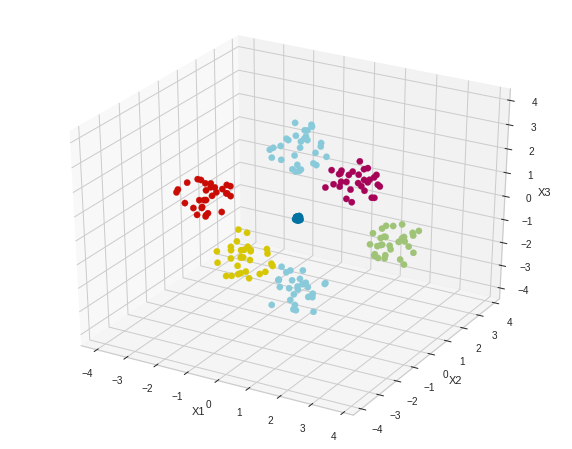

In [ ]:
df_data1 = pd.read_csv('Data1.csv')
x=df_data1['X1']
y=df_data1['X2']
z=df_data1['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data1['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 2

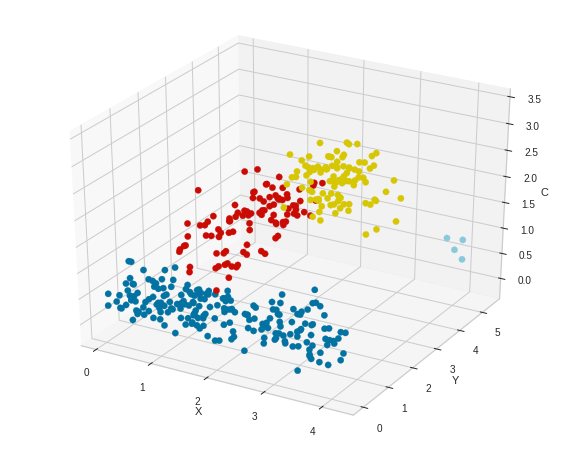

In [ ]:
df_data2 = pd.read_csv('Data2.csv')
x=df_data2['X']
y=df_data2['Y']
z=df_data2['C']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data2['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 3

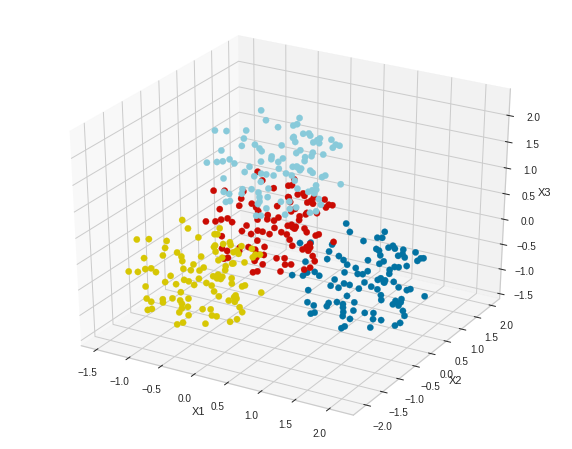

In [ ]:
df_data3 = pd.read_csv('Data3.csv')
x=df_data3['X1']
y=df_data3['X2']
z=df_data3['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data3['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 4

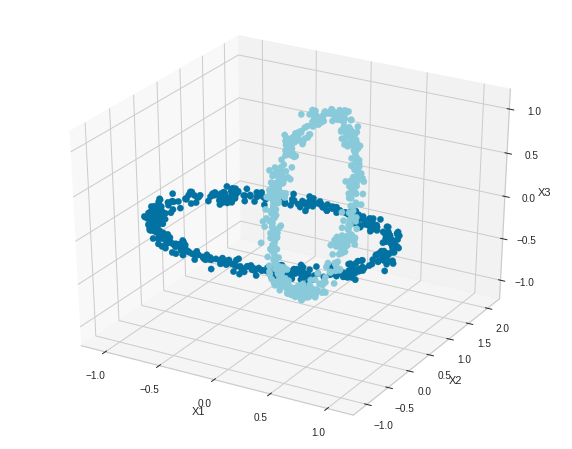

In [ ]:
df_data4 = pd.read_csv('Data4.csv')
x=df_data4['X1']
y=df_data4['X2']
z=df_data4['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data4['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 5

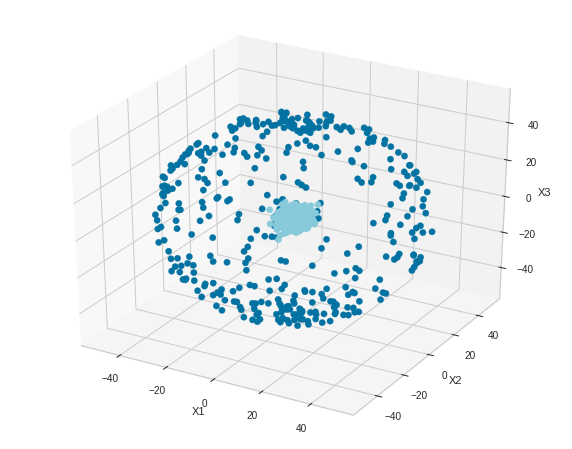

In [ ]:
df_data5 = pd.read_csv('Data5.csv')
x=df_data5['X1']
y=df_data5['X2']
z=df_data5['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data5['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 6

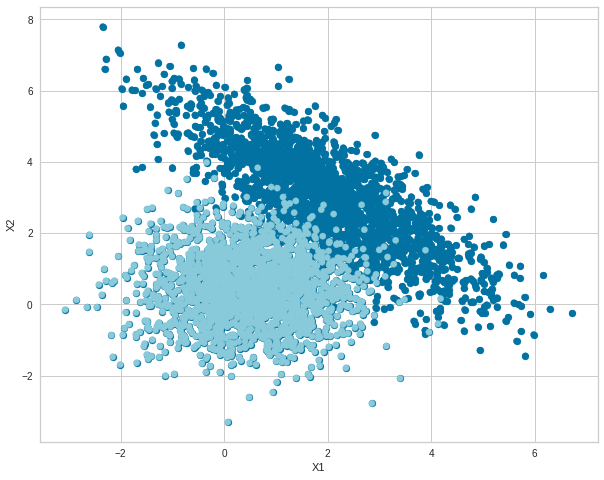

In [ ]:
df_data6 = pd.read_csv('Data6.csv')
x=df_data6['X1']
y=df_data6['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = df_data6['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 7

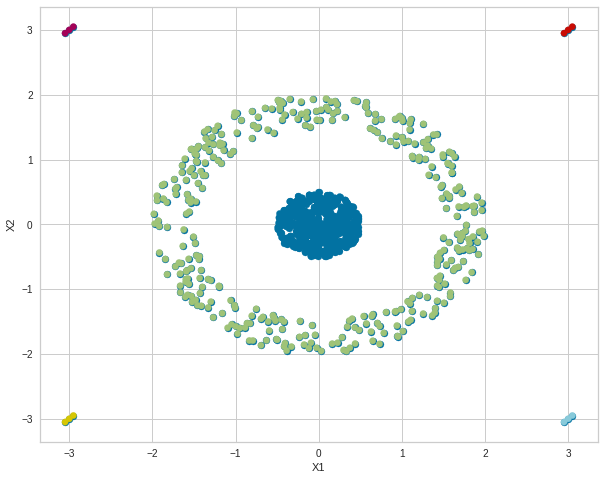

In [ ]:
df_data7 = pd.read_csv('Data7.csv')
x=df_data7['X1']
y=df_data7['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = df_data7['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

### Gourndtruth graph Dataset 8

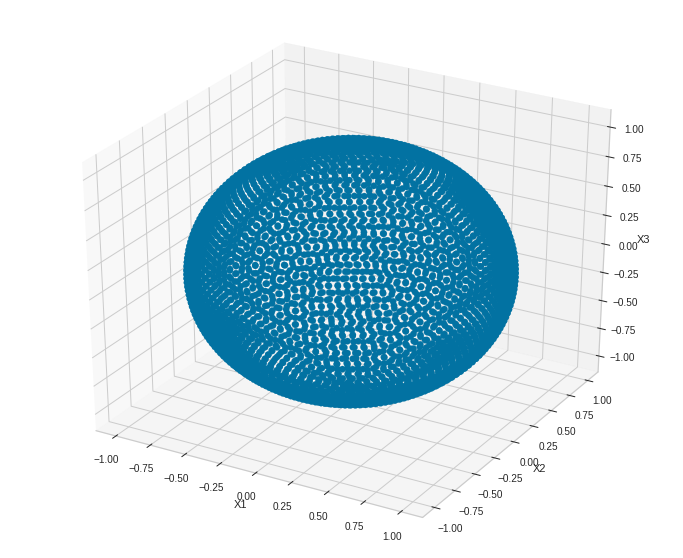

In [ ]:
df_data8 = pd.read_csv('Data8.csv')
x=df_data8['X1']
y=df_data8['X2']
z=df_data8['X3']
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data8['Class'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

## KMeans cluster

### Dataset 1

### Performing the K means cluster Accuracy&F1 score for dataset 1

In [ ]:
data1_f1, data1_acc, new_pred_df_1 = kmeans(df_data1, 3, 7)
print(f"ACC: {data1_acc}, F1: {data1_f1}")
df_data1

ACC: 1.0, F1: 1.0


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-0.063274,0.027734,0.022683,1,1
1,2,-0.000731,0.048211,0.069198,1,1
2,3,-0.060767,-0.009080,0.053085,1,1
3,4,0.013252,-0.011876,0.055324,1,1
4,5,-0.054508,-0.003813,0.001738,1,1
...,...,...,...,...,...,...
207,208,0.175738,-0.053478,-2.733752,7,7
208,209,0.396046,-0.858377,-3.126866,7,7
209,210,-0.406362,-0.334541,-2.885598,7,7
210,211,-0.299275,0.071281,-3.642585,7,7


### Drawing the graph through the Kmeans cluster of dataset1

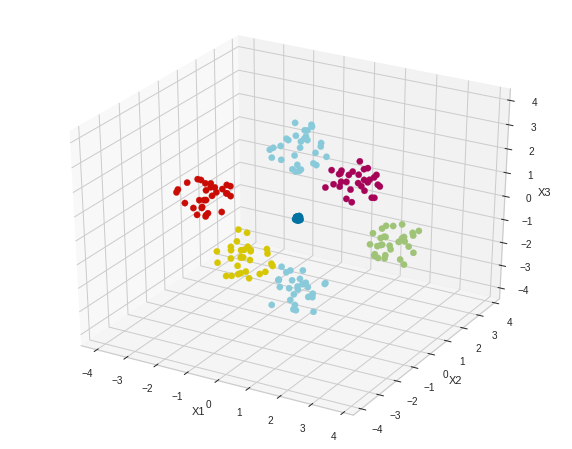

In [ ]:
x=df_data1['X1']
y=df_data1['X2']
z=df_data1['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data1['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 1 is 1.0 and F1 score is also 1.0 by using KMeans clustering method. Then we can conclude that for dataset 1 we have all of our datapoints in True Positive&True Negative sets, which means we have the perfect clustering method that all predicted datapoints are in the right position as groundtruth. We can also have a comparison between this graph and the Groundtruth graph and we can see there's no significant difference.

### Dataset 2

### Performing the K means cluster Accuracy&F1 score for dataset 2

In [ ]:
data2_f1, data2_acc, new_pred_df_2 = kmeans(df_data2, 3, 4)
print(f"ACC: {data2_acc}, F1: {data2_f1}")
df_data2

ACC: 0.7252475247524752, F1: 0.6326653633105246


,Unnamed: 0,X,Y,C,Class,pred
0,X1,3.277701,0.814082,0.326574,1,4
1,X2,0.387577,0.176780,0.888046,1,1
2,X3,0.268546,0.582963,0.080981,1,1
3,X4,2.031145,0.244597,0.643921,1,4
4,X5,0.188677,0.461280,0.496633,1,1
...,...,...,...,...,...,...
399,X400,3.248655,2.297291,3.388138,3,3
400,X,4.100000,5.100000,0.504558,4,2
401,X.1,3.900000,4.900000,0.941634,4,2
402,X.2,4.000000,5.000000,0.702123,4,2


### Drawing the graph through the Kmeans cluster of dataset2

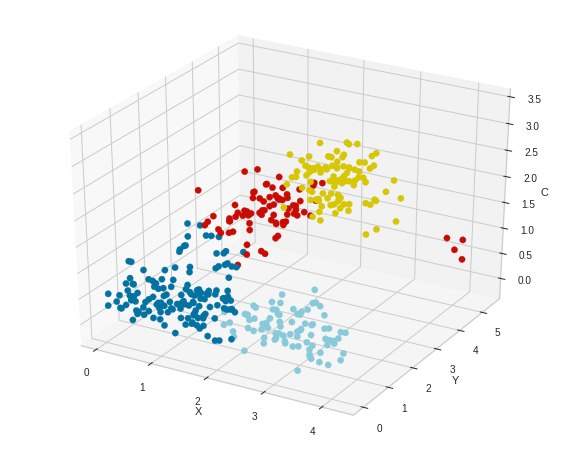

In [ ]:
x=df_data2['X']
y=df_data2['Y']
z=df_data2['C']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data2['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 2 is nearly 0.725 and F1 score is 0.633 by using KMeans clustering method. Then we can conclude that for dataset 2 we have some errors by using the kmeans method and we can also see the errors in the graph above by comparing the groundtruth graph and KMeans clustering graph. Therefore, we have to consider whether to use this method depending on specific cases. According to the definition of Accuracy and F1 score, if the the FP and FN are important, we need to have more attention on the F1 score and the F1 score is 0.63267 so that we need to consider this carefully. However, if the TP and TN is important, we should pay more attention on the Accuracy score and the score is 0.72525 which is relatively high.

### Dataset 3

### Performing the K means cluster Accuracy&F1 score for dataset 3

In [ ]:
df_data3 = pd.read_csv('Data3.csv')
data3_f1, data3_acc, new_pred_df_3 = kmeans(df_data3, 3, 4)
print(f"ACC: {data3_acc}, F1: {data3_f1}")
df_data3

ACC: 1.0, F1: 1.0


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,1.295428,0.050829,-0.385217,1,1
1,2,1.409178,-0.035191,-0.251980,1,1
2,3,1.096803,0.246365,-0.415011,1,1
3,4,1.463328,0.265354,-0.513488,1,1
4,5,1.603284,0.080577,-0.470257,1,1
...,...,...,...,...,...,...
395,396,0.795695,0.209456,1.880609,4,4
396,397,0.653127,-0.703156,1.549448,4,4
397,398,-0.726249,-0.103244,0.694300,4,4
398,399,0.808596,-0.492640,1.649370,4,4


### Drawing the graph through the Kmeans cluster of dataset3

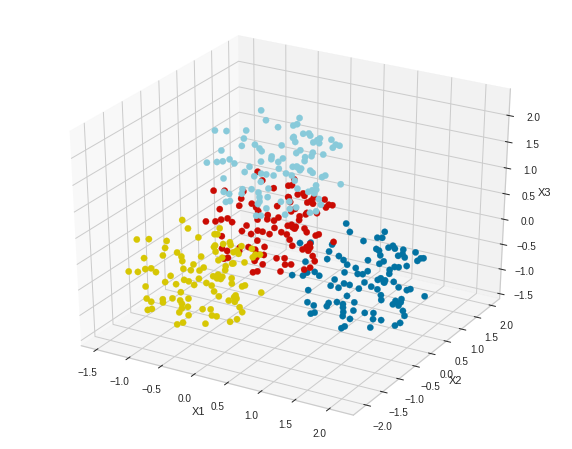

In [ ]:
x=df_data3['X1']
y=df_data3['X2']
z=df_data3['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data3['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 3 is 1.0 and F1 score is also 1.0 by using KMeans clustering method. Then we can conclude that for dataset 3 we have all of our datapoints in True Positive&True Negative sets, which means we have the perfect clustering method that all predicted datapoints are in the right position as groundtruth. We can also have a comparison between this graph and the Groundtruth graph and we can see there's no significant difference.

### Dataset 4

### Performing the K means cluster Accuracy&F1 score for dataset 4

In [ ]:
df_data4 = pd.read_csv('Data4.csv')
data4_f1, data4_acc, new_pred_df_4 = kmeans(df_data4, 3, 2)
print(f"ACC: {data4_acc}, F1: {data4_f1}")
df_data4

ACC: 0.653, F1: 0.6529996529996529


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-0.45300,-0.8910,0.02300,1,1
1,2,0.65300,-0.8460,0.02110,1,1
2,3,0.39800,0.9130,-0.00139,1,2
3,4,0.09520,1.0500,0.00628,1,2
4,5,0.52400,-0.9410,0.03780,1,1
...,...,...,...,...,...,...
995,996,0.01520,0.0531,-0.36100,2,1
996,997,0.05160,0.6910,0.87500,2,2
997,998,-0.00511,1.3900,-0.94700,2,2
998,999,-0.06710,0.7140,0.88100,2,2


### Drawing the graph through the Kmeans cluster of dataset4

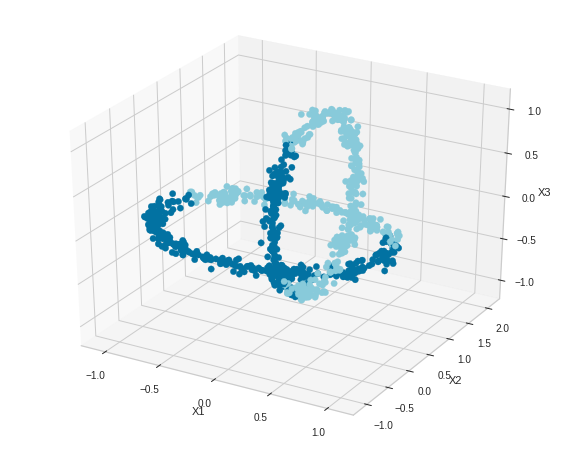

In [ ]:
x=df_data4['X1']
y=df_data4['X2']
z=df_data4['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data4['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 4 is 0.653 and F1 score is also nearly 0.653 by using KMeans clustering method. Then we can conclude that for dataset 4 we have some errors by using the kmeans method and we can also see the errors in the graph above by comparing the groundtruth graph and KMeans clustering graph. Therefore, we have to consider whether to use this method. Because the F1 score and the Accuracy have the same value and both are relatively low, so that we have to consider this method really carefully before we actually utilize this method on this dataset in real world.

### Dataset 5

### Performing the K means cluster Accuracy&F1 score for dataset 5

In [ ]:
df_data5 = pd.read_csv('Data5.csv')
data5_f1, data5_acc, new_pred_df_5 = kmeans(df_data5,3, 2)
print(f"ACC: {data5_acc}, F1: {data5_f1}")
df_data5

ACC: 0.71375, F1: 0.6882015252936301


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-4.822490,-50.402170,4.020861,1,2
1,2,-44.460120,20.964670,-11.492060,1,2
2,3,50.001020,0.780748,9.134460,1,2
3,4,-41.699080,-22.310060,16.314120,1,1
4,5,4.425242,-4.666664,50.223740,1,1
...,...,...,...,...,...,...
795,796,-1.531027,0.681636,0.543271,2,2
796,797,0.500754,-1.848209,0.605654,2,2
797,798,1.089574,-0.246493,-3.355758,2,2
798,799,-1.907717,4.964502,2.098423,2,2


### Drawing the graph through the Kmeans cluster of dataset 5

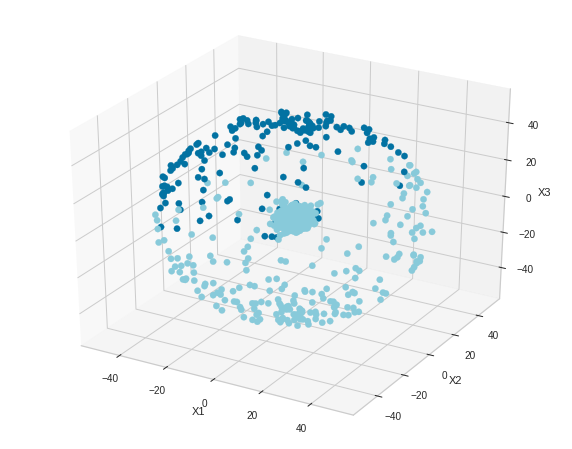

In [ ]:
x=df_data5['X1']
y=df_data5['X2']
z=df_data5['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data5['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 5 is 0.714 and F1 score is also nearly 0.688 by using KMeans clustering method. Then we can conclude that for dataset 5 we also have some errors and we can see those errors by comparing the groundtruth graph and KMeans clustering graph. However, the errors are in the accepted range that we have our Accuracy score and F1 score nearly 0.7. We can still using KMeans clustering in this dataset.

### Dataset 6

### Performing the K means cluster Accuracy&F1 score for dataset 6

In [ ]:
df_data6 = pd.read_csv('Data6.csv')
data6_f1, data6_acc, new_pred_df_6 = kmeans(df_data6,2, 2)
print(f"ACC: {data6_acc}, F1: {data6_f1}")
df_data6

ACC: 0.951416015625, F1: 0.9513828386139447


,Unnamed: 0,X1,X2,Class,pred
0,1,1.388261,2.076096,1,1
1,2,2.177247,3.102304,1,1
2,3,0.378645,5.307610,1,1
3,4,3.681732,1.622681,1,1
4,5,2.462861,2.777897,1,1
...,...,...,...,...,...
4091,4092,0.909687,0.375763,2,2
4092,4093,2.698381,0.511262,2,2
4093,4094,1.078797,1.526153,2,2
4094,4095,1.974889,-0.649343,2,2


### Drawing the graph through the Kmeans cluster of dataset 6

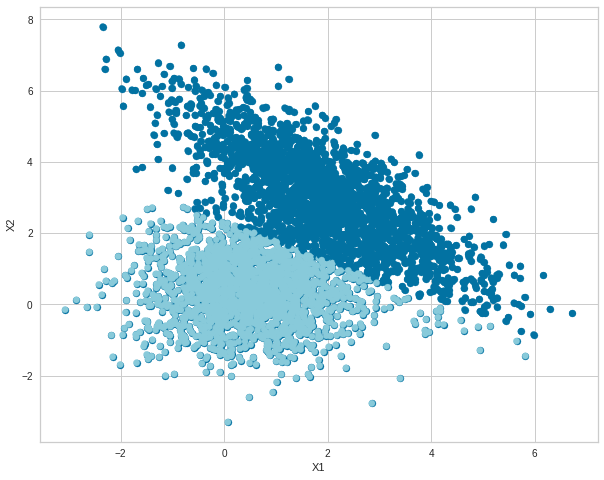

In [ ]:
x=df_data6['X1']
y=df_data6['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = df_data6['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 6 is nearly 0.951 and F1 score is also nealy 0.951 by using KMeans clustering method. Then we can conclude that there are only few errors by using the KMeans clustering method. The method is nearly perfect. We can also see there is no significant difference between the graph above and the groundtruth graph.

### Dataset 7

### Performing the K means cluster Accuracy&F1 score for dataset 7

In [ ]:
df_data7 = pd.read_csv('Data7.csv')
data7_f1, data7_acc, new_pred_df_7 = kmeans(df_data7, 2, 6)
print(f"ACC: {data7_acc}, F1: {data7_f1}")
df_data7

ACC: 0.6337662337662338, F1: 0.267908031846388


,Unnamed: 0,X1,X2,Class,pred
0,1,-3.000000,-3.000000,5,2
1,2,-3.000000,3.000000,4,4
2,3,3.000000,-3.000000,6,6
3,4,3.000000,3.000000,3,3
4,5,-0.417091,0.114782,1,1
...,...,...,...,...,...
765,766,-1.604434,-1.118861,2,2
766,767,-3.050000,-3.050000,5,2
767,768,-3.050000,2.950000,4,4
768,769,2.950000,-3.050000,6,6


### Drawing the graph through the Kmeans cluster of dataset 7

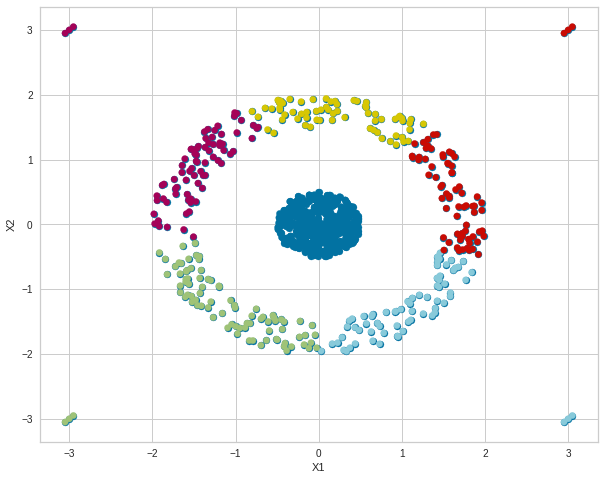

In [ ]:
x=df_data7['X1']
y=df_data7['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = df_data7['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 7 is nearly 0.639 and F1 score is noly nearly 0.272 by using KMeans clustering method. Then we can conclude that for dataset 7 there are relatively many errors by using the KMeans method. In some specific cases if the FN and FP have really important meaning, then we should not use this method for clustering.

### Dataset 8

### Performing the K means cluster Accuracy&F1 score for dataset 8

In [ ]:
df_data8 = pd.read_csv('Data8.csv')
data8_f1, data8_acc, new_pred_df_8= kmeans(df_data8, 3, 1)
print(f"ACC: {data8_acc}, F1: {data8_f1}")
df_data8

ACC: 1.0, F1: 1.0


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,0.000000,0.000000,1.00000,1,1
1,2,0.000000,0.052336,0.99863,1,1
2,3,0.049774,0.016173,0.99863,1,1
3,4,0.030762,-0.042341,0.99863,1,1
4,5,-0.030762,-0.042341,0.99863,1,1
...,...,...,...,...,...,...
3997,3998,0.049774,-0.016173,-0.99863,1,1
3998,3999,0.000000,-0.052336,-0.99863,1,1
3999,4000,-0.049774,-0.016173,-0.99863,1,1
4000,4001,-0.030762,0.042341,-0.99863,1,1


### Drawing the graph through the Kmeans cluster of dataset 8

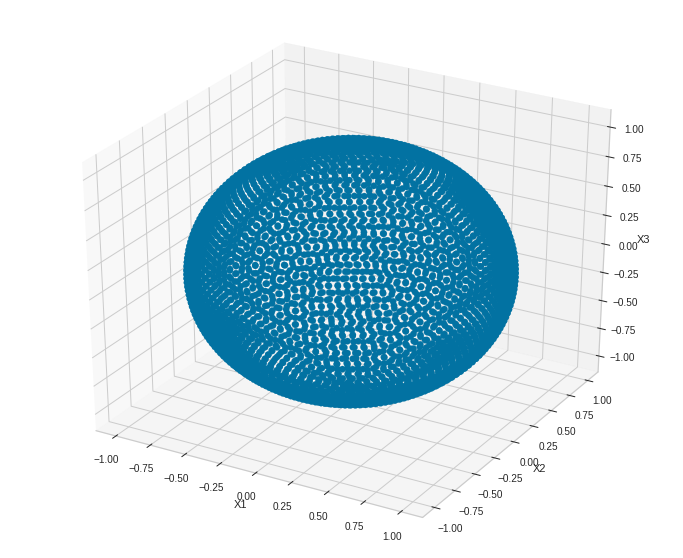

In [ ]:
x=df_data8['X1']
y=df_data8['X2']
z=df_data8['X3']
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = df_data8['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 8 is 1.0 and F1 score is also 1.0 by using KMeans clustering method. Then we can conclude that for dataset 8 we have all of our datapoints in True Positive&True Negative sets, which means we have the perfect clustering method that all predicted datapoints are in the right position as groundtruth. We can also have a comparison between this graph and the Groundtruth graph and we can see there's no significant difference.

## Hierarchical Cluster

### Dataset 1

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data1 = pd.read_csv('Data1.csv')
data1_f1, data1_acc, new_pred_df_1h = hierarchical(df_data1, 3, 7)
print(f"ACC: {data1_acc}, F1: {data1_f1}")
df_data1

ACC: 1.0, F1: 1.0


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-0.063274,0.027734,0.022683,1,1
1,2,-0.000731,0.048211,0.069198,1,1
2,3,-0.060767,-0.009080,0.053085,1,1
3,4,0.013252,-0.011876,0.055324,1,1
4,5,-0.054508,-0.003813,0.001738,1,1
...,...,...,...,...,...,...
207,208,0.175738,-0.053478,-2.733752,7,7
208,209,0.396046,-0.858377,-3.126866,7,7
209,210,-0.406362,-0.334541,-2.885598,7,7
210,211,-0.299275,0.071281,-3.642585,7,7


### Drawing the Dendrogram of hierarchical cluster

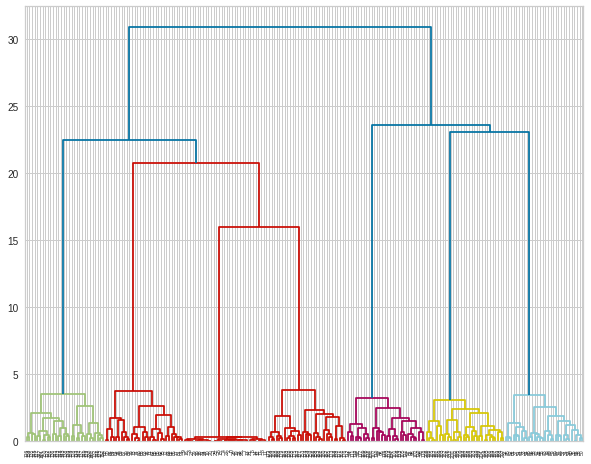

In [ ]:
data1h = list(zip(df_data1['X1'], df_data1['X2'], df_data1['X3']))
linkage_data1h = linkage(data1h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data1h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

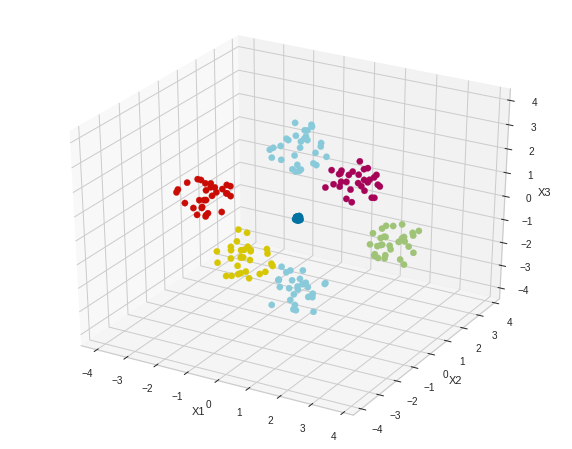

In [ ]:
x=df_data1['X1']
y=df_data1['X2']
z=df_data1['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_1h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 1 is 1.0 and F1 score is also 1.0 by using hierarchical clustering method. Then we can conclude that for dataset 1 we have all of our datapoints in True Positive&True Negative sets, which means we have the perfect clustering method, which means all predicted datapoints are in the right position as groundtruth. We can also have a comparison between this graph and the Groundtruth graph and we can see there's no significant difference. Therefore, the hierarchical clustering and KMeans clustering are the same for this dataset

### Dataset 2

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data2 = pd.read_csv('Data2.csv')
data2_f1, data2_acc, new_pred_df_2h = hierarchical(df_data2, 3, 4)
print(f"ACC: {data2_acc}, F1: {data2_f1}")
df_data2

ACC: 0.8193069306930693, F1: 0.6929832355903086


,Unnamed: 0,X,Y,C,Class,pred
0,X1,3.277701,0.814082,0.326574,1,4
1,X2,0.387577,0.176780,0.888046,1,1
2,X3,0.268546,0.582963,0.080981,1,1
3,X4,2.031145,0.244597,0.643921,1,1
4,X5,0.188677,0.461280,0.496633,1,1
...,...,...,...,...,...,...
399,X400,3.248655,2.297291,3.388138,3,3
400,X,4.100000,5.100000,0.504558,4,2
401,X.1,3.900000,4.900000,0.941634,4,2
402,X.2,4.000000,5.000000,0.702123,4,2


### Drawing the Dendrogram of hierarchical cluster

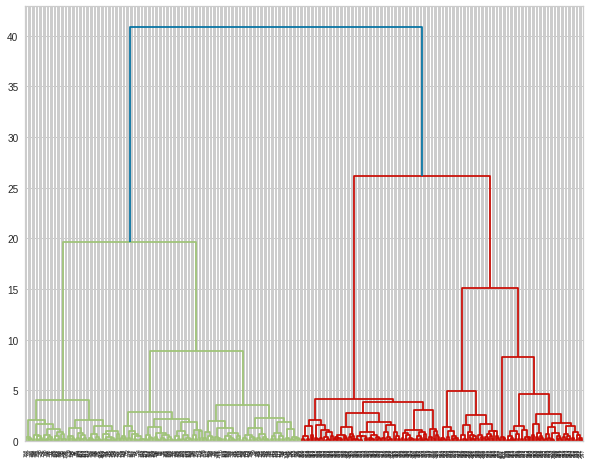

In [ ]:
data2h = list(zip(df_data2['X'], df_data2['Y'], df_data2['C']))
linkage_data2h = linkage(data2h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data2h)

plt.show()

### Drawing the scatter plot of the hierarchical cluster

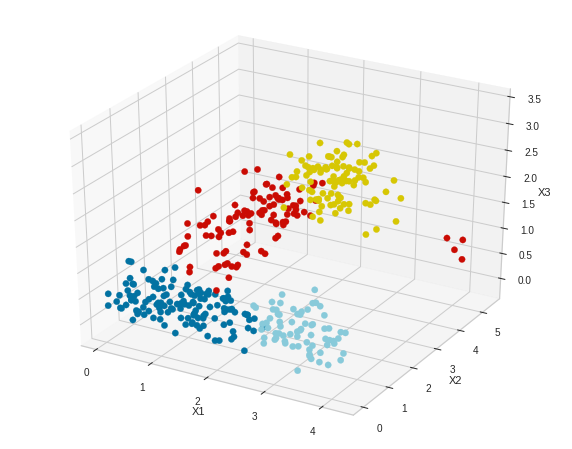

In [ ]:
x=df_data2['X']
y=df_data2['Y']
z=df_data2['C']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_2h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 2 is nearly 0.819 and F1 score is nearly 0.693 by using hierarchical clustering method. Then we can conclude that for dataset 2 a few errors and we can also see the difference by comparing the graph above and the groundtruth graph. Moreover, we have higher accuracy and F1 score by using the hierarchical method than using the KMeans method. Therefore, we should use the hierachical method for the dataset 2 rather than the KMeans.

### Dataset 3

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data3 = pd.read_csv('Data3.csv')
data3_f1, data3_acc, new_pred_df_3h = hierarchical(df_data3, 3, 4)
print(f"ACC: {data3_acc}, F1: {data3_f1}")
df_data3

ACC: 0.9875, F1: 0.9874921826141339


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,1.295428,0.050829,-0.385217,1,1
1,2,1.409178,-0.035191,-0.251980,1,1
2,3,1.096803,0.246365,-0.415011,1,1
3,4,1.463328,0.265354,-0.513488,1,1
4,5,1.603284,0.080577,-0.470257,1,1
...,...,...,...,...,...,...
395,396,0.795695,0.209456,1.880609,4,4
396,397,0.653127,-0.703156,1.549448,4,4
397,398,-0.726249,-0.103244,0.694300,4,4
398,399,0.808596,-0.492640,1.649370,4,4


### Drawing the Dendrogram of hierarchical cluster

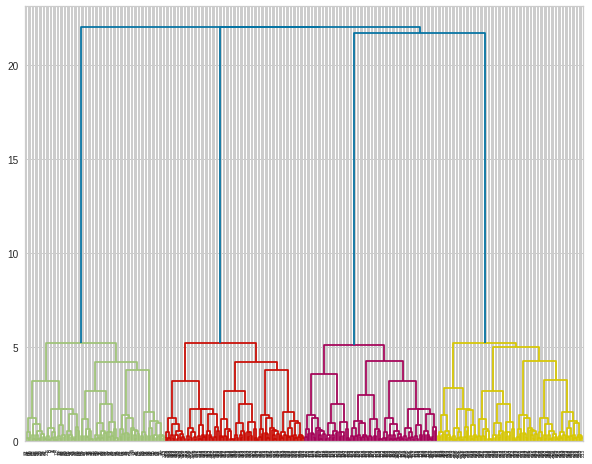

In [ ]:
data3h = list(zip(df_data3['X1'], df_data3['X2'], df_data3['X3']))
linkage_data3h = linkage(data3h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data3h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

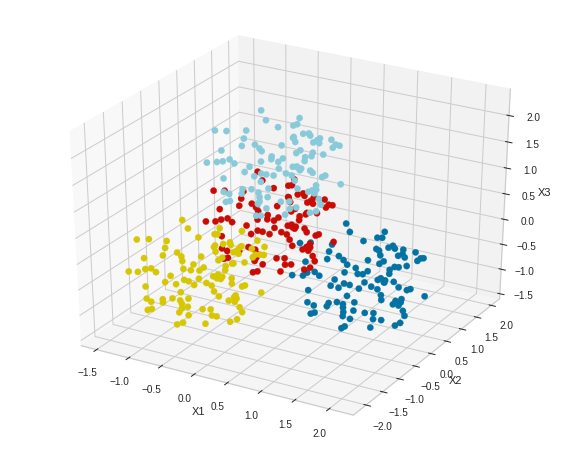

In [ ]:
x=df_data3['X1']
y=df_data3['X2']
z=df_data3['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_3h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 3 is nearly 0.988 and F1 score is nearly 0.987 by using hierarchical clustering method. Then we can conclude that for dataset 3 few errors by the calculation but there are no big difference between the graphs. However, if we use the calculation we can conclude that the KMeans is a bettwe way to cluster the dataset.

### Dataset 4

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data4 = pd.read_csv('Data4.csv')
data4_f1, data4_acc, new_pred_df_4h = hierarchical(df_data4, 3, 2)
print(f"ACC: {data4_acc}, F1: {data4_f1}")
df_data4

ACC: 0.799, F1: 0.7905375057706396


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-0.45300,-0.8910,0.02300,1,1
1,2,0.65300,-0.8460,0.02110,1,1
2,3,0.39800,0.9130,-0.00139,1,2
3,4,0.09520,1.0500,0.00628,1,2
4,5,0.52400,-0.9410,0.03780,1,1
...,...,...,...,...,...,...
995,996,0.01520,0.0531,-0.36100,2,2
996,997,0.05160,0.6910,0.87500,2,2
997,998,-0.00511,1.3900,-0.94700,2,2
998,999,-0.06710,0.7140,0.88100,2,2


### Drawing the Dendrogram of hierarchical cluster

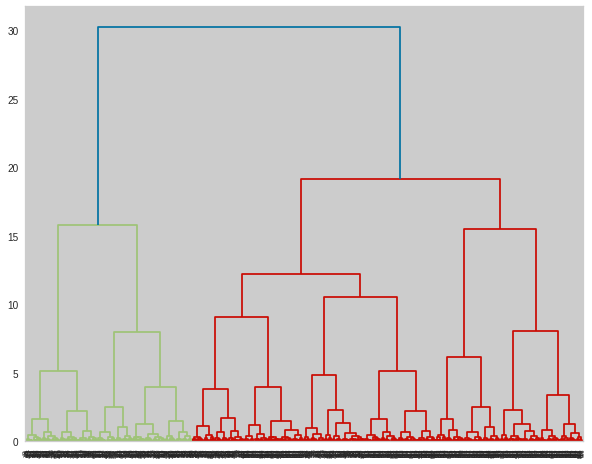

In [ ]:
data4h = list(zip(df_data4['X1'], df_data4['X2'], df_data4['X3']))
linkage_data4h = linkage(data4h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data4h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

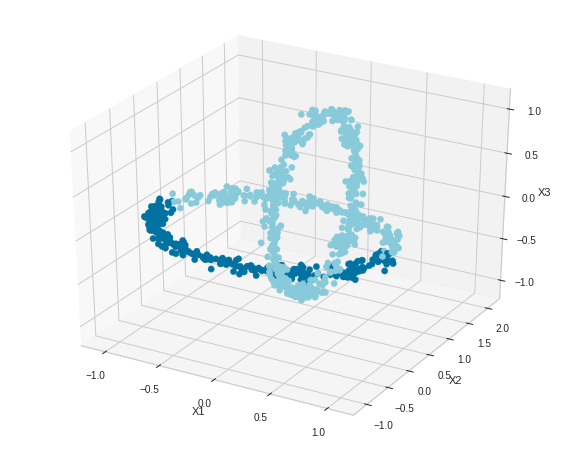

In [ ]:
x=df_data4['X1']
y=df_data4['X2']
z=df_data4['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_4h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 4 is nearly 0.799 and F1 score is nearly 0.791 by using hierarchical clustering method. Then we can conclude that for dataset 4 a few errors and we can also see the difference by comparing the graph above and the groundtruth graph. Moreover, we have higher accuracy and F1 score by using the hierarchical method than using the KMeans method. Therefore, we should use the hierachical method for the dataset 4 rather than the KMeans.

### Dataset 5

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data5 = pd.read_csv('Data5.csv')
data5_f1, data5_acc,new_pred_df_5h = hierarchical(df_data5, 3, 2)
print(f"ACC: {data5_acc}, F1: {data5_f1}")
df_data5

ACC: 0.6575, F1: 0.6119832048204714


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,-4.822490,-50.402170,4.020861,1,1
1,2,-44.460120,20.964670,-11.492060,1,2
2,3,50.001020,0.780748,9.134460,1,2
3,4,-41.699080,-22.310060,16.314120,1,2
4,5,4.425242,-4.666664,50.223740,1,2
...,...,...,...,...,...,...
795,796,-1.531027,0.681636,0.543271,2,2
796,797,0.500754,-1.848209,0.605654,2,2
797,798,1.089574,-0.246493,-3.355758,2,2
798,799,-1.907717,4.964502,2.098423,2,2


### Drawing the Dendrogram of hierarchical cluster

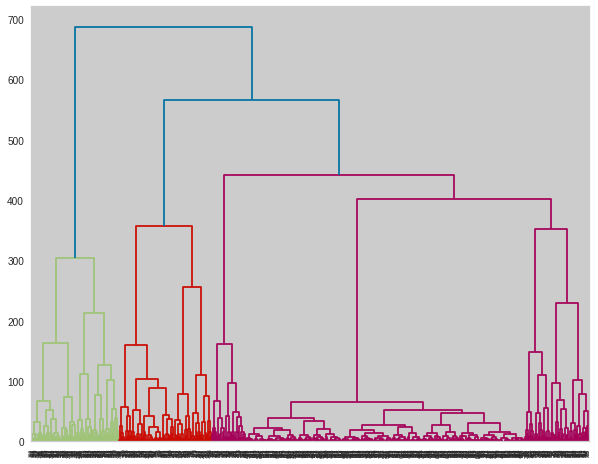

In [ ]:
data5h = list(zip(df_data5['X1'], df_data5['X2'], df_data5['X3']))
linkage_data5h = linkage(data5h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data5h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

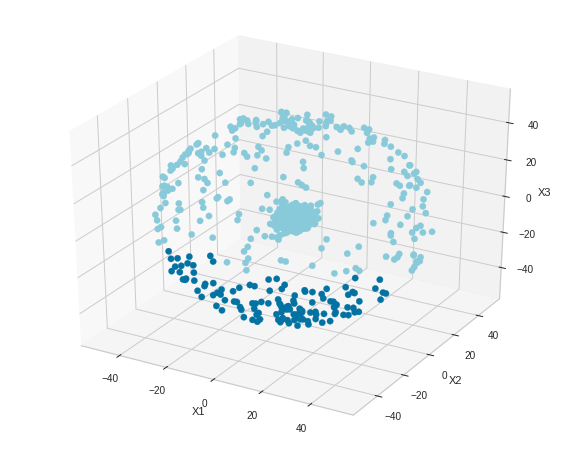

In [ ]:
x=df_data5['X1']
y=df_data5['X2']
z=df_data5['X3']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_5h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 5 is nearly 0.657 and F1 score is nearly 0.612 by using hierarchical clustering method. Then we can conclude that for dataset 5 a few errors and we can also see the difference by comparing the graph above and the groundtruth graph. Moreover, we have lower accuracy and F1 score by using the hierarchical method than using the KMeans method. Therefore, we should use the KMeans method for the dataset 5 rather than the hierachical.

### Dataset 6

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data6 = pd.read_csv('Data6.csv')
data6_f1, data6_acc, new_pred_df_6h = hierarchical(df_data6, 2, 2)
print(f"ACC: {data6_acc}, F1: {data6_f1}")
df_data6

ACC: 0.923828125, F1: 0.9235478572495148


,Unnamed: 0,X1,X2,Class,pred
0,1,1.388261,2.076096,1,1
1,2,2.177247,3.102304,1,1
2,3,0.378645,5.307610,1,1
3,4,3.681732,1.622681,1,1
4,5,2.462861,2.777897,1,1
...,...,...,...,...,...
4091,4092,0.909687,0.375763,2,2
4092,4093,2.698381,0.511262,2,1
4093,4094,1.078797,1.526153,2,2
4094,4095,1.974889,-0.649343,2,2


### Drawing the Dendrogram of hierarchical cluster

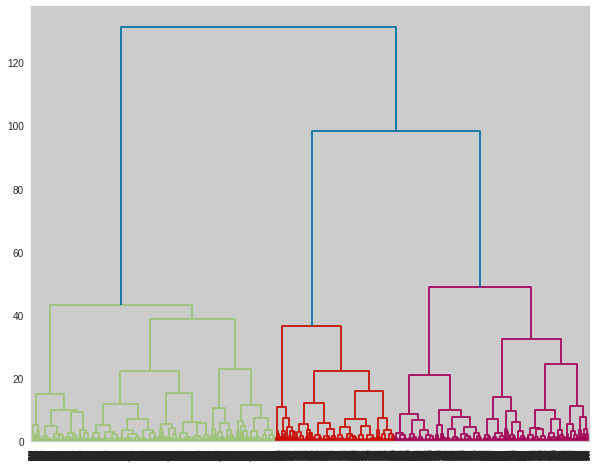

In [ ]:
data6h = list(zip(df_data6['X1'], df_data6['X2']))
linkage_data6h = linkage(data6h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data6h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

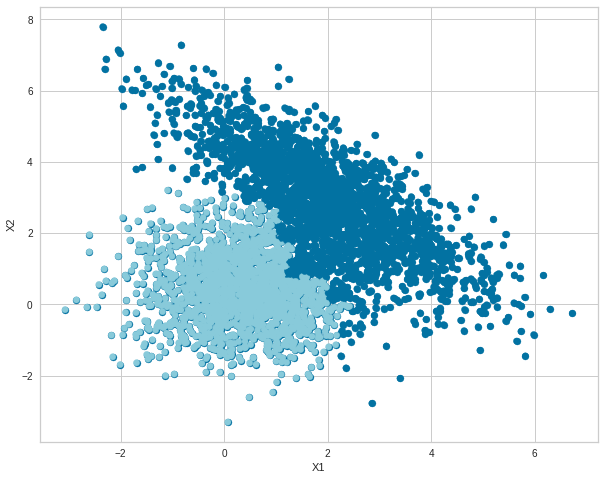

In [ ]:
x=df_data6['X1']
y=df_data6['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = new_pred_df_6h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 6 is nearly 0.923 and F1 score is nearly 0.923 by using hierarchical clustering method. Then we can conclude that for dataset 6 a few errors and we can also see the difference by comparing the graph above and the groundtruth graph. Moreover, we have lower accuracy and F1 score by using the hierarchical method than using the KMeans method. Therefore, we should use the KMeans method for the dataset 6 rather than the hierachical.

### Dataset 7

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data7 = pd.read_csv('Data7.csv')
data7_f1, data7_acc, new_pred_df_7h = hierarchical(df_data7,2, 6)
print(f"ACC: {data7_acc}, F1: {data7_f1}")
df_data7

ACC: 0.6558441558441559, F1: 0.277655545506537


,Unnamed: 0,X1,X2,Class,pred
0,1,-3.000000,-3.000000,5,5
1,2,-3.000000,3.000000,4,4
2,3,3.000000,-3.000000,6,2
3,4,3.000000,3.000000,3,3
4,5,-0.417091,0.114782,1,1
...,...,...,...,...,...
765,766,-1.604434,-1.118861,2,5
766,767,-3.050000,-3.050000,5,5
767,768,-3.050000,2.950000,4,4
768,769,2.950000,-3.050000,6,2


### Drawing the Dendrogram of hierarchical cluster

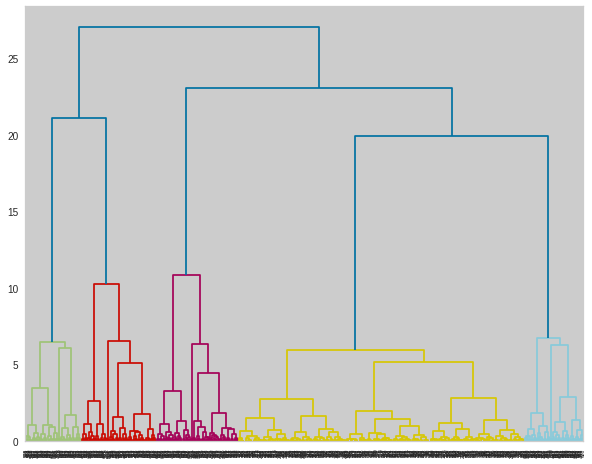

In [ ]:
data7h = list(zip(df_data7['X1'], df_data7['X2']))
linkage_data7h = linkage(data7h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data7h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

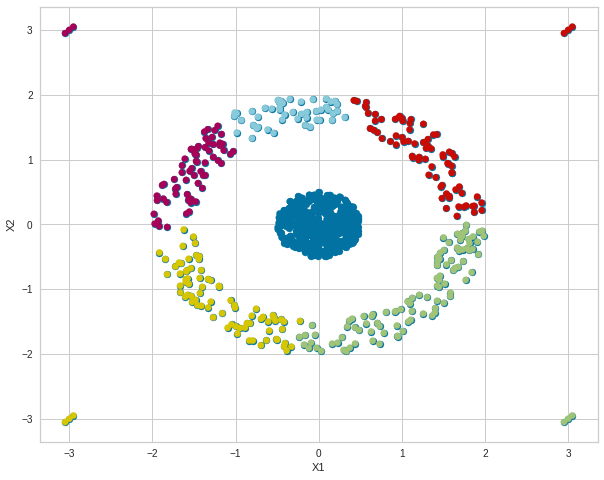

In [ ]:
x=df_data7['X1']
y=df_data7['X2']
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,s = 40,c = new_pred_df_7h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 7 is nearly 0.656 and F1 score is nearly 0.278 by using hierarchical clustering method. Then we can conclude that for dataset 7 errors exists and we can also see the significant difference by comparing the graph above and the groundtruth graph. Moreover, For both hierarchical and KMeans method, we both have low value on F1 score, so we might have to find some other methods on computing the clustering process if the FP and FN play some really important roles in the specific case.

### Dataset 8

### Perform the hierarchical cluster and accuracy score&F1 score test

In [ ]:
df_data8 = pd.read_csv('Data8.csv')
data8_f1, data8_acc, new_pred_df_8h = hierarchical(df_data8, 3, 1)
print(f"ACC: {data8_acc}, F1: {data8_f1}")
df_data8

ACC: 1.0, F1: 1.0


,Unnamed: 0,X1,X2,X3,Class,pred
0,1,0.000000,0.000000,1.00000,1,1
1,2,0.000000,0.052336,0.99863,1,1
2,3,0.049774,0.016173,0.99863,1,1
3,4,0.030762,-0.042341,0.99863,1,1
4,5,-0.030762,-0.042341,0.99863,1,1
...,...,...,...,...,...,...
3997,3998,0.049774,-0.016173,-0.99863,1,1
3998,3999,0.000000,-0.052336,-0.99863,1,1
3999,4000,-0.049774,-0.016173,-0.99863,1,1
4000,4001,-0.030762,0.042341,-0.99863,1,1


### Drawing the Dendrogram of hierarchical cluster


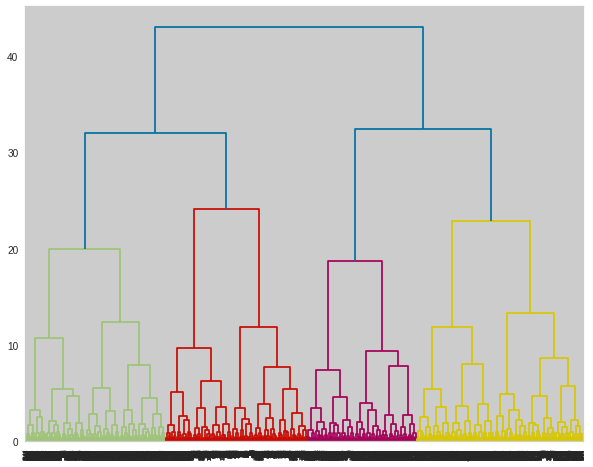

In [ ]:
data8h = list(zip(df_data8['X1'], df_data8['X2'],df_data8['X3']))
linkage_data8h = linkage(data8h, method='ward', metric='euclidean')
plt.figure(figsize = (10,8))
dendrogram(linkage_data8h)
plt.show()

### Drawing the scatter plot of the hierarchical cluster

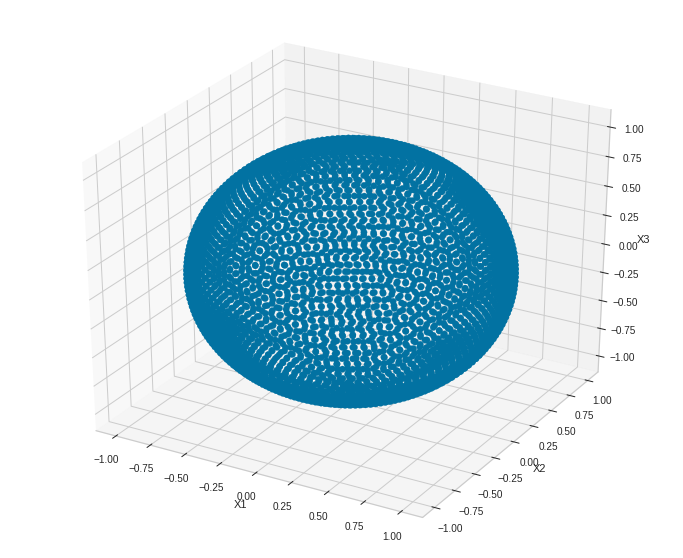

In [ ]:
x=df_data8['X1']
y=df_data8['X2']
z=df_data8['X3']
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111,projection = '3d')
scatter = ax.scatter(x,y,z)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
cmap = matplotlib.colors.ListedColormap(sns.color_palette().as_hex())
sc = ax.scatter(x,y,z,s = 40,c = new_pred_df_8h['pred'],marker = 'o',cmap = cmap,alpha = 1)
fig.show()

The Accuracy score for dataset 8 is 1.0 and F1 score is also 1.0 by using hierarchical clustering method. Then we can conclude that for dataset 8 we have all of our datapoints in True Positive&True Negative sets, which means we have the perfect clustering method, which means all predicted datapoints are in the right position as groundtruth. We can also have a comparison between this graph and the Groundtruth graph and we can see there's no significant difference. Therefore, the hierarchical clustering and KMeans clustering are the same for this dataset.

# Task 2

## Data cleaning process

In [ ]:
task2=pd.read_csv('World Indicators.csv')
task2

,Birth Rate,Business Tax Rate,Days to Start Business,Energy Usage,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Lending Interest,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country
0,0.025,72.0%,25.0,41852.0,"$199,070,864,638",0.044,$233,451.0,0.023,0.1,0.080,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria
1,0.046,52.1%,66.0,13576.0,"$104,115,863,405",0.034,$178,282.0,0.107,0.1,0.188,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola
2,0.037,65.9%,29.0,3761.0,"$7,294,900,431",0.045,$34,270.0,0.060,0.0,NaN,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin
3,0.024,19.5%,60.0,2215.0,"$15,292,424,757",0.052,$404,152.0,0.039,0.1,0.110,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana
4,0.042,43.5%,13.0,NaN,"$10,395,757,480",0.064,$39,270.0,0.068,0.0,NaN,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.907,The Americas,Turks and Caicos Islands
204,0.013,46.5%,5.0,2191193.0,"$15,533,800,000,000",0.177,"$8,467",187.0,0.006,0.7,0.033,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States
205,0.015,41.9%,7.0,4430.0,"$47,236,710,623",0.088,"$1,213",336.0,0.010,0.5,0.098,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay
206,0.020,62.8%,141.0,70198.0,"$316,482,176,579",0.045,$487,864.0,0.014,0.4,0.172,77.0,71.0,1.0,0.291,0.651,0.058,0.888,The Americas,"Venezuela, RB"


In [ ]:
task2.isnull().sum() #Checking for Nulls

Birth Rate                 9
Business Tax Rate         27
Days to Start Business    27
Energy Usage              72
GDP                       20
Health Exp % GDP          23
Health Exp/Capita         23
Hours to do Tax           28
Infant Mortality Rate     20
Internet Usage             9
Lending Interest          77
Life Expectancy Female    11
Life Expectancy Male      11
Mobile Phone Usage        12
Population 0-14           17
Population 15-64          17
Population 65+            17
Population Urban           2
Region                     0
Country                    0
dtype: int64

In [ ]:
task2.drop(['Energy Usage','Lending Interest'],axis=1,inplace=True) #Dropping Energy usage and Lending Interest columns from the data as they have maximum null values

In [ ]:
task2.describe()
task2.dtypes #Checking for columns that are strings, so that they can be changed to float data type

Birth Rate                float64
Business Tax Rate          object
Days to Start Business    float64
GDP                        object
Health Exp % GDP          float64
Health Exp/Capita          object
Hours to do Tax           float64
Infant Mortality Rate     float64
Internet Usage            float64
Life Expectancy Female    float64
Life Expectancy Male      float64
Mobile Phone Usage        float64
Population 0-14           float64
Population 15-64          float64
Population 65+            float64
Population Urban          float64
Region                     object
Country                    object
dtype: object

In [ ]:
task2['Business Tax Rate']=task2['Business Tax Rate'].str.rstrip('%').astype('float')#Removing the unwanted characters liek % and $ from the columns that contain them and setting their data type as float
task2['GDP']=task2['GDP'].str.lstrip('$').str.replace(',','').astype('float')
task2['Health Exp/Capita']=task2['Health Exp/Capita'].str.lstrip('$').str.replace(',','').astype('float')
task2

,Birth Rate,Business Tax Rate,Days to Start Business,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country
0,0.025,72.0,25.0,1.990709e+11,0.044,233.0,451.0,0.023,0.1,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria
1,0.046,52.1,66.0,1.041159e+11,0.034,178.0,282.0,0.107,0.1,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola
2,0.037,65.9,29.0,7.294900e+09,0.045,34.0,270.0,0.060,0.0,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin
3,0.024,19.5,60.0,1.529242e+10,0.052,404.0,152.0,0.039,0.1,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana
4,0.042,43.5,13.0,1.039576e+10,0.064,39.0,270.0,0.068,0.0,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.907,The Americas,Turks and Caicos Islands
204,0.013,46.5,5.0,1.553380e+13,0.177,8467.0,187.0,0.006,0.7,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States
205,0.015,41.9,7.0,4.723671e+10,0.088,1213.0,336.0,0.010,0.5,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay
206,0.020,62.8,141.0,3.164822e+11,0.045,487.0,864.0,0.014,0.4,77.0,71.0,1.0,0.291,0.651,0.058,0.888,The Americas,"Venezuela, RB"


In [ ]:
task2.dropna(inplace=True)
task2#Dropping the missing values that are remained from the data

,Birth Rate,Business Tax Rate,Days to Start Business,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country
0,0.025,72.0,25.0,1.990709e+11,0.044,233.0,451.0,0.023,0.1,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria
1,0.046,52.1,66.0,1.041159e+11,0.034,178.0,282.0,0.107,0.1,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola
2,0.037,65.9,29.0,7.294900e+09,0.045,34.0,270.0,0.060,0.0,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin
3,0.024,19.5,60.0,1.529242e+10,0.052,404.0,152.0,0.039,0.1,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana
4,0.042,43.5,13.0,1.039576e+10,0.064,39.0,270.0,0.068,0.0,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.018,27.9,694.0,4.363219e+09,0.060,490.0,199.0,0.022,0.3,74.0,67.0,1.0,0.283,0.652,0.065,0.663,The Americas,Suriname
202,0.015,29.1,41.0,2.367635e+10,0.053,935.0,210.0,0.020,0.6,73.0,66.0,1.4,0.207,0.708,0.085,0.089,The Americas,Trinidad and Tobago
204,0.013,46.5,5.0,1.553380e+13,0.177,8467.0,187.0,0.006,0.7,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States
205,0.015,41.9,7.0,4.723671e+10,0.088,1213.0,336.0,0.010,0.5,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay


In [ ]:
valid_data_percentage=171/208
valid_data_percentage

0.8221153846153846

We can see that we still have over 80 percent valid data in our processed dataframe which means hte processed dataframe is valid for us to use in the task 2.

## Scaling the data and performing KMeans Elbow method to find the optimum k(number of clusters) value and plotting it for each number of clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Worldindicators')

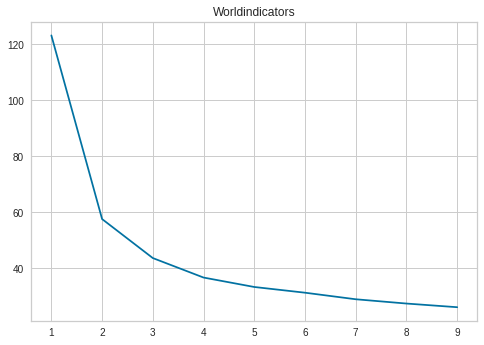

In [ ]:
# KMeans Elbow method
scaler=MinMaxScaler()
data=scaler.fit_transform(task2.iloc[:,0:16])
x = []
distance = []
for i in range(1,10):
  md = KMeans(n_clusters=i)
  md.fit(data)
  x.append(i)
  distance.append(md.inertia_)
sns.lineplot(x,distance)
plt.title('Worldindicators')

## Calculating the Silhouette coefficient for the data to find the optimum number of clusters and plotting its value for each k

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


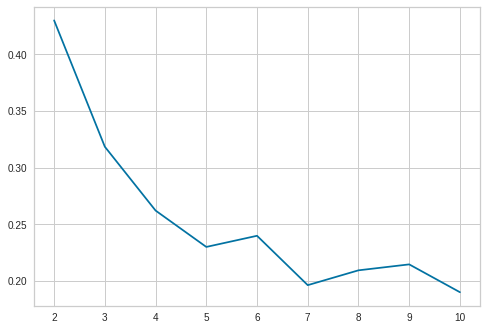

In [ ]:
from sklearn.metrics import silhouette_score
data=scaler.fit_transform(task2.iloc[:,0:16])
silhouette_coef = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data)
  labels = kmeans.labels_
  silhouette_coef.append(silhouette_score(data, labels, metric = 'euclidean'))
sns.lineplot(range(2,11),silhouette_coef)

## To find the distortion score in order to get the k value we are importimg KElbowVisualizer and plotting the elbow curve

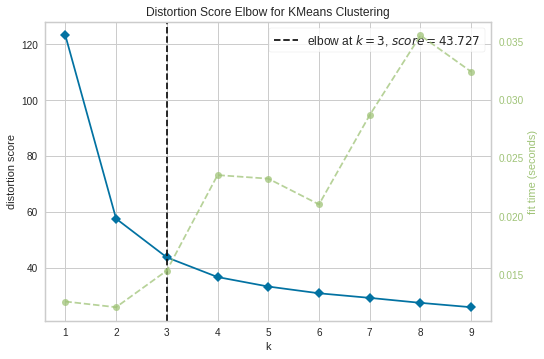

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model=KMeans()
viz=KElbowVisualizer(model,k=(1,10),timings=True,locate_elbow=True)
viz.fit(data)
viz.show()

In [ ]:
# Assigning and adding the column "class" to the original dataframe which tells what data point belongs to what class
md=KMeans(n_clusters=3)
md.fit(data)
task2['KMeans Class']=md.labels_
task2

,Birth Rate,Business Tax Rate,Days to Start Business,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country,KMeans Class
0,0.025,72.0,25.0,1.990709e+11,0.044,233.0,451.0,0.023,0.1,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria,0
1,0.046,52.1,66.0,1.041159e+11,0.034,178.0,282.0,0.107,0.1,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola,2
2,0.037,65.9,29.0,7.294900e+09,0.045,34.0,270.0,0.060,0.0,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin,2
3,0.024,19.5,60.0,1.529242e+10,0.052,404.0,152.0,0.039,0.1,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana,2
4,0.042,43.5,13.0,1.039576e+10,0.064,39.0,270.0,0.068,0.0,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.018,27.9,694.0,4.363219e+09,0.060,490.0,199.0,0.022,0.3,74.0,67.0,1.0,0.283,0.652,0.065,0.663,The Americas,Suriname,0
202,0.015,29.1,41.0,2.367635e+10,0.053,935.0,210.0,0.020,0.6,73.0,66.0,1.4,0.207,0.708,0.085,0.089,The Americas,Trinidad and Tobago,0
204,0.013,46.5,5.0,1.553380e+13,0.177,8467.0,187.0,0.006,0.7,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States,1
205,0.015,41.9,7.0,4.723671e+10,0.088,1213.0,336.0,0.010,0.5,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay,1


From K-Means Clustering we can say that K=3, Now let's try doing the Hierarchical clustering and see which K value best suits the data

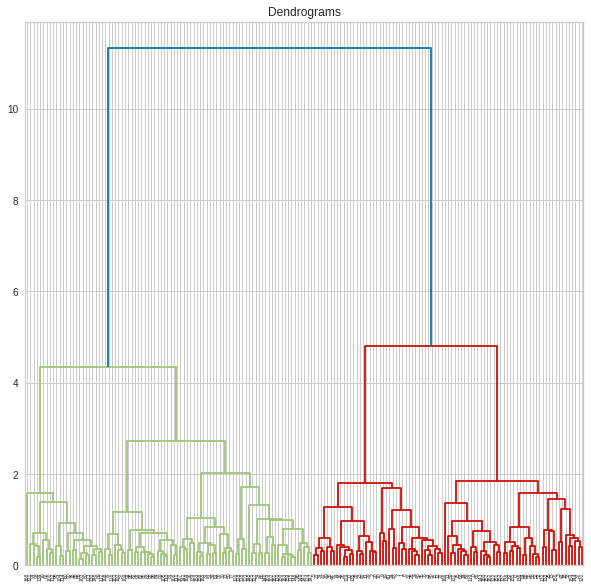

In [ ]:
# Hierarchical Clustering
data_scaled = data
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled,method='ward'))

From the dendogram we can say that K = 2

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')  
cluster.fit_predict(data)
task2['Hierarchical Class']=cluster.labels_
task2

,Birth Rate,Business Tax Rate,Days to Start Business,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country,KMeans Class,Hierarchical Class
0,0.025,72.0,25.0,1.990709e+11,0.044,233.0,451.0,0.023,0.1,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria,0,0
1,0.046,52.1,66.0,1.041159e+11,0.034,178.0,282.0,0.107,0.1,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola,2,0
2,0.037,65.9,29.0,7.294900e+09,0.045,34.0,270.0,0.060,0.0,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin,2,0
3,0.024,19.5,60.0,1.529242e+10,0.052,404.0,152.0,0.039,0.1,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana,2,0
4,0.042,43.5,13.0,1.039576e+10,0.064,39.0,270.0,0.068,0.0,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.018,27.9,694.0,4.363219e+09,0.060,490.0,199.0,0.022,0.3,74.0,67.0,1.0,0.283,0.652,0.065,0.663,The Americas,Suriname,0,0
202,0.015,29.1,41.0,2.367635e+10,0.053,935.0,210.0,0.020,0.6,73.0,66.0,1.4,0.207,0.708,0.085,0.089,The Americas,Trinidad and Tobago,0,1
204,0.013,46.5,5.0,1.553380e+13,0.177,8467.0,187.0,0.006,0.7,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States,1,1
205,0.015,41.9,7.0,4.723671e+10,0.088,1213.0,336.0,0.010,0.5,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay,1,1


Then we have a contradict that whether to use k=2 or k=3 to do the clustering by using the KMeans and Hierarchical. Because from the elbow method we can see that the k should be 3 for KMeans method but for Dendrogram the k should be 2 for Hierarchical. Then we should have a test on both of them to find which method is better.

## Comparing the Silhouette values, Dunn Index Values and CH Values for both, KMeans and Hierarchical Clustering, for the number of clusters = 2 and clusters = 3.

In [ ]:
from validclust import ValidClust

vclust_object_1 = ValidClust(k = [2,3] , methods = ['hierarchical', 'kmeans'])

cvi_values = vclust_object_1.fit_predict(data)

print(cvi_values)

                                  2           3
method       index                             
hierarchical silhouette    0.417640    0.290832
             calinski    184.879962  134.980602
             davies        0.906605    1.151703
             dunn          0.141426    0.156691
kmeans       silhouette    0.429875    0.317549
             calinski    192.545251  152.629179
             davies        0.880359    1.100751
             dunn          0.121921    0.150141


Silhouette score should be higher for a better clustering,as the silhoutte score works on distance and of the fact that the clusters formed are far from each other and are coherent , so we go for K=2 that is suggested by KMeans clustering.

performing the kmeans clustering as k=2

In [ ]:
md=KMeans(n_clusters=2)
md.fit(data)
task2['KMeans Class']=md.labels_
task2

,Birth Rate,Business Tax Rate,Days to Start Business,GDP,Health Exp % GDP,Health Exp/Capita,Hours to do Tax,Infant Mortality Rate,Internet Usage,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Population 0-14,Population 15-64,Population 65+,Population Urban,Region,Country,KMeans Class,Hierarchical Class
0,0.025,72.0,25.0,1.990709e+11,0.044,233.0,451.0,0.023,0.1,72.0,69.0,0.9,0.272,0.681,0.047,0.682,Africa,Algeria,1,0
1,0.046,52.1,66.0,1.041159e+11,0.034,178.0,282.0,0.107,0.1,53.0,50.0,0.5,0.477,0.499,0.024,0.409,Africa,Angola,1,0
2,0.037,65.9,29.0,7.294900e+09,0.045,34.0,270.0,0.060,0.0,60.0,58.0,0.8,0.432,0.539,0.029,0.423,Africa,Benin,1,0
3,0.024,19.5,60.0,1.529242e+10,0.052,404.0,152.0,0.039,0.1,46.0,47.0,1.5,0.340,0.625,0.035,0.565,Africa,Botswana,1,0
4,0.042,43.5,13.0,1.039576e+10,0.064,39.0,270.0,0.068,0.0,56.0,55.0,0.5,0.458,0.517,0.025,0.265,Africa,Burkina Faso,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.018,27.9,694.0,4.363219e+09,0.060,490.0,199.0,0.022,0.3,74.0,67.0,1.0,0.283,0.652,0.065,0.663,The Americas,Suriname,0,0
202,0.015,29.1,41.0,2.367635e+10,0.053,935.0,210.0,0.020,0.6,73.0,66.0,1.4,0.207,0.708,0.085,0.089,The Americas,Trinidad and Tobago,0,1
204,0.013,46.5,5.0,1.553380e+13,0.177,8467.0,187.0,0.006,0.7,81.0,76.0,0.9,0.197,0.669,0.133,0.809,The Americas,United States,0,1
205,0.015,41.9,7.0,4.723671e+10,0.088,1213.0,336.0,0.010,0.5,80.0,73.0,1.4,0.223,0.638,0.139,0.946,The Americas,Uruguay,0,1


Groupby the countries and see the list of them

In [ ]:
new_1 = list(task2.loc[task2['KMeans Class'] == 0, 'Country'])
new_1

['Egypt, Arab Rep.',
 'Mauritius',
 'Morocco',
 'Seychelles',
 'Tunisia',
 'Armenia',
 'Azerbaijan',
 'Brunei Darussalam',
 'China',
 'Georgia',
 'Japan',
 'Kazakhstan',
 'Korea, Rep.',
 'Malaysia',
 'Singapore',
 'Sri Lanka',
 'Thailand',
 'Vietnam',
 'Albania',
 'Austria',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Macedonia, FYR',
 'Malta',
 'Moldova',
 'Montenegro',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russian Federation',
 'Serbia',
 'Slovak Republic',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Kingdom',
 'Bahrain',
 'Iran, Islamic Rep.',
 'Israel',
 'Jordan',
 'Kuwait',
 'Lebanon',
 'Oman',
 'Qatar',
 'Saudi Arabia',
 'United Arab Emirates',
 'Australia',
 'Fiji',
 'New Zealand',
 'Antigua and Bar

In [ ]:
new_2 = list(task2.loc[task2['KMeans Class'] == 1, 'Country'])
new_2

['Algeria',
 'Angola',
 'Benin',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Djibouti',
 'Equatorial Guinea',
 'Eritrea',
 'Ethiopia',
 'Gabon',
 'Gambia, The',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Kenya',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Namibia',
 'Niger',
 'Nigeria',
 'Rwanda',
 'Sao Tome and Principe',
 'Senegal',
 'Sierra Leone',
 'South Africa',
 'Sudan',
 'Swaziland',
 'Tanzania',
 'Togo',
 'Uganda',
 'Zambia',
 'Afghanistan',
 'Bangladesh',
 'Bhutan',
 'Cambodia',
 'India',
 'Indonesia',
 'Kyrgyz Republic',
 'Lao PDR',
 'Mongolia',
 'Nepal',
 'Pakistan',
 'Philippines',
 'Tajikistan',
 'Timor-Leste',
 'Uzbekistan',
 'Iraq',
 'Yemen, Rep.',
 'Kiribati',
 'Micronesia, Fed. Sts.',
 'Papua New Guinea',
 'Solomon Islands',
 'Tonga',
 'Vanuatu',
 'Belize',
 'Bolivia',
 'Guatemala',
 'Guyana',
 'Haiti',
 'Ho

We can see a trend between the Birth Rate and Population 0-14 for all the countries. These 2 groups look like they have a large correlation between them. The clustering is quite good and we can easily distinguish between the 2 clusters.

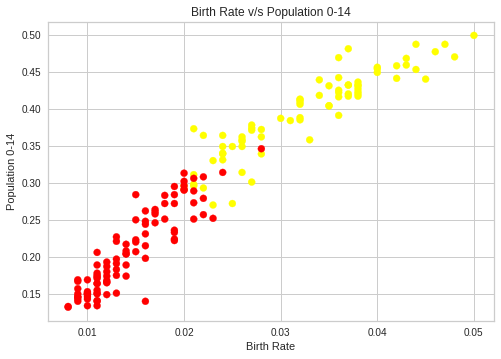

In [ ]:
import matplotlib
cmap_new_1 = matplotlib.colors.ListedColormap(['red' , 'yellow'])
plt.scatter(task2['Birth Rate'], task2['Population 0-14'], c = task2['KMeans Class'], cmap = cmap_new_1)
plt.title('Birth Rate v/s Population 0-14')
plt.xlabel('Birth Rate')
plt.ylabel('Population 0-14')
plt.show()

We can also see a trend between the Birth Rate and Life Expectancy of Females for all the countries. These 2 groups look like they have some sort of correlation between them. The clustering is also quite good and we can easily distinguish between the 2 clusters. We can observe that when Birth Rate increases, the Life Expectancy of Females decreases and vice-versa

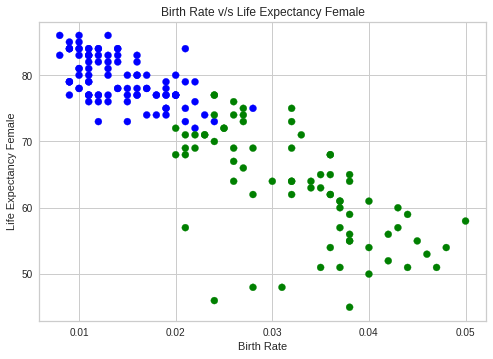

In [ ]:
cmap_new_2 = matplotlib.colors.ListedColormap(['blue' , 'green'])
plt.scatter(task2['Birth Rate'], task2['Life Expectancy Female'], c = task2['KMeans Class'], cmap = cmap_new_2)
plt.title('Birth Rate v/s Life Expectancy Female')
plt.xlabel('Birth Rate')
plt.ylabel('Life Expectancy Female')
plt.show()

There also exists a trend between the Birth Rate and the Internet Usage across all the countries. The clustering is very good and the 2 clusters can easily be identified. We can see that when the Birth Rate increases , the Internet Usage decreases and vice versa.

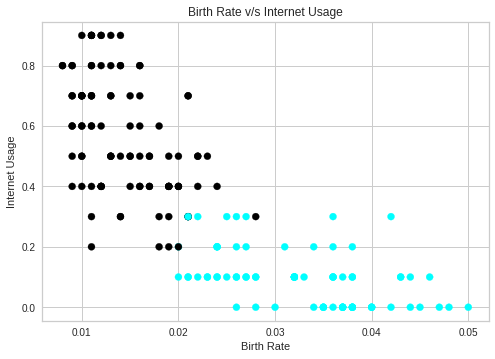

In [ ]:
cmap_new_3 = matplotlib.colors.ListedColormap(['black' , 'cyan'])
plt.scatter(task2['Birth Rate'], task2['Internet Usage'], c = task2['KMeans Class'], cmap = cmap_new_3)
plt.title('Birth Rate v/s Internet Usage')
plt.xlabel('Birth Rate')
plt.ylabel('Internet Usage')
plt.show()

We can also see a trend between the Health Expenditure per Capita and the Internet Usage across all the countries. These 2 groups look like they have a correlation between them. The clustering is actually very good and we can easily distinguish between the 2 clusters. It is easily observed that when the Internet Usage increases, the Health Expenditure per Capita also increases.

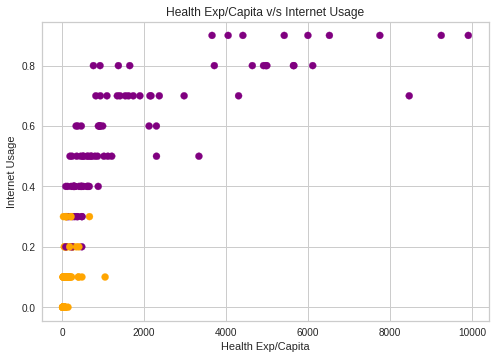

In [ ]:
cmap_new_4 = matplotlib.colors.ListedColormap(['purple' , 'orange'])
plt.scatter(task2['Health Exp/Capita'], task2['Internet Usage'], c = task2['KMeans Class'], cmap = cmap_new_4)
plt.title('Health Exp/Capita v/s Internet Usage')
plt.xlabel('Health Exp/Capita')
plt.ylabel('Internet Usage')
plt.show()

# Convert to html